In [16]:
import qgrid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import socket as socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
import h5py

### hapROH imports
#sys.path.insert(0,"/n/groups/reich/hringbauer/git/HAPSBURG/package/")  # hack to get development package first in path
sys.path.insert(0,"/n/groups/reich/hringbauer/git/hapBLOCK/package/hapBLOCK/IO/")  # hack to get development package first in path
from h5_load import get_coverage,get_genos_pairs,get_idx_iid,get_idx_iid_exact,get_markers_good

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/hapBLOCK/"  # The Path on Harvard Cluster
else:
    raise RuntimeWarning("No compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns

print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

sys.path.insert(0, path)

compute-a-17-99.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/hapBLOCK
CPU Count: 32


# Prepare the data

In [2]:
f = h5py.File("./data/hdf5/1240k_v43/ch3.h5", "r") # Load for Sanity Check. See below!

In [3]:
%%time
cutoff=0.98
gps = f["calldata/GP"][:,:,:]
m = np.max(gps, axis=2)
idx = (m>cutoff)

CPU times: user 49.2 s, sys: 11.4 s, total: 1min
Wall time: 1min 2s


In [4]:
%%time
gts = f["calldata/GT"][:,:,:]
gt = np.sum(gts, axis=2)
gt[~idx]=1 # Set low quality data to heterozygotes

CPU times: user 14.2 s, sys: 3.26 s, total: 17.5 s
Wall time: 17.6 s


In [5]:
### Figure out the wacky indiviuals
m_ind = np.mean(idx, axis=0)
idx_iid = (m_ind>0.5)

In [6]:
samples1 = f["samples"][idx_iid]
m_ind1 = m_ind[idx_iid] # Average for the good Individuals
gt1 = gt[:,idx_iid]  # Takes the longest time
idx1 = idx[:,idx_iid] # Get the index of good loci
print(f"Extracted {len(samples1)} Samples with good enough coverage")

Extracted 9813 Samples with good enough coverage


In [7]:
%%time
homo = (gt1 == 0)
homo2 = (gt1 == 2)

CPU times: user 907 ms, sys: 336 ms, total: 1.24 s
Wall time: 1.24 s


# Intermezzo: Sharing for 1 indiviual with rest

In [95]:
%%time
i=0
opp_homo = (homo[:,i][:,None] & homo2[:,:]) | (homo2[:,i][:,None] & homo[:,:])
good_loci = idx1[:,i][:,None] & idx1[:,:] # Both Loci there

opp_homo_ind = np.sum(opp_homo, axis=0)
o_homo_fracs = opp_homo_ind / np.sum(good_loci, axis=0)

CPU times: user 1.18 s, sys: 666 ms, total: 1.85 s
Wall time: 1.85 s


# Create the sharing Matrix [run many individuals in paralllel]

In [21]:
n=np.shape(homo)[1]
frac_mat = -np.ones((n,n), dtype="float")  # Matrix of sharing

In [ ]:
%%time

for i in range(n):
    opp_homo = (homo[:,i][:,None] & homo2[:,i:]) | (homo2[:,i][:,None] & homo[:,i:]) # Opposing homozygotes
    good_loci = idx1[:,i][:,None] & idx1[:,i:] # Both Loci good quality

    opp_homo_ind = np.sum(opp_homo, axis=0)
    o_homo_fracs = opp_homo_ind / np.sum(good_loci, axis=0)
    frac_mat[i,i:] = o_homo_fracs
print("finished the job")

In [25]:
frac_mat[-2,:]

array([-1.       , -1.       , -1.       , ..., -1.       ,  0.       ,
        0.0516349])

In [26]:
frac_mat1 = frac_mat

(9813, 9813)

In [ ]:
np.savetxt("./output/dumpster/frac_mat_all9813.tsv", frac_mat, delimiter='\t')
np.savetxt("./output/dumpster/samples_9813.tsv", samples1, fmt="%s", delimiter='\t')

In [ ]:
idx_pair = np.where((frac_mat[:,:]<0.0005) & (frac_mat[:,:]>0))
print(f"Found {len(idx_pair[0])} putative pairs found")

df = pd.DataFrame({"iid1":samples1[idx_pair[0]], "iid2":samples1[idx_pair[1]],
                   "opp_homo_rate_ch3":frac_mat[idx_pair]})

In [ ]:
df.to_csv("./output/dumpster/o_homo_all_001.tsv", sep="\t", index=False)

### Further Processing

In [ ]:
samples1 =np.loadtxt("./output/dumpster/full_run_ch3_9813/samples_9813.tsv", dtype="str")
f_mat = np.loadtxt("./output/dumpster/full_run_ch3_9813/frac_mat_all9813.tsv")
print(np.shape(samples1))
print(np.shape(f_mat))
np.fill_diagonal(f_mat, -1) ### Modifies matrix in place

In [ ]:
idx_pair = np.where((f_mat[:,:]<0.0005) & (f_mat[:,:]>=0))
print(f"Found {len(idx_pair[0])} putative pairs found")

df = pd.DataFrame({"iid1":samples1[idx_pair[0]], "iid2":samples1[idx_pair[1]],
                   "opp_homo_rate_ch3":f_mat[idx_pair]})

df.to_csv("./output/dumpster/full_run_ch3_9813/o_homo_all_0005.tsv", sep="\t", index=False)

# Rerun the inferred relatives on all chromosomes
[needs list of relatives, produced elsewhere]

In [48]:
def get_o_homo_frac_pair(f, iid1="BR2.SG",iid2="I18209", cutoff=0.98):
    """Calculate Fraction of opposing homozygotes for iid1, iid2 in hdf5 f"""
    gt1, gt2, _ = get_genos_pairs(f, sample1=iid1, sample2=iid2,
                              cutoff=0.98, output=False,  phased=False, exact=True)

    gts = np.concatenate((gt1[:,None], gt2[:,None]), axis=1)
    homo = (gts == 0)
    homo2 = (gts == 2)

    opp_homo = (homo[:,0] & homo2[:,1]) | (homo2[:,0] & homo[:,1])

    o_homo_fracs = np.mean(opp_homo)
    return o_homo_fracs

### Run all chromosomes for all pair in list

In [118]:
#df = pd.read_csv("./output/relatives_snp/opp_homos_ch3_processed_unique_novel.tsv", sep="\t")
df = pd.read_csv("./output/relatives_snp/opp_homos_ch3_processed_uniqye.tsv", sep="\t")
df_po = df[df["relatedness"] == "Parent Offspring"]
print(f"Loaded {len(df_po)} parent offspring pair")

Loaded 333 parent offspring pair


In [119]:
%%time
df1 = df_po.copy()
o_homo_mat = -np.ones((len(df_po),22), dtype="float")
for ch in range(1,23):
    f = h5py.File(f"./data/hdf5/1240k_v43/ch{ch}.h5", "r") # Load for Sanity Check. See below!
    for j,(iid1,iid2) in enumerate(df_po[["iid1", "iid2"]].values):
        h = get_o_homo_frac_pair(f, iid1=iid1, iid2=iid2)
        o_homo_mat[j,ch-1]=h
    df1[f"opp_homo_rate_ch{ch}"]=o_homo_mat[:,ch-1]
    
df1[f"max_opp_homo_ch"] = np.max(o_homo_mat, axis=1)
df1[f"opp_homo_mean"] = np.mean(o_homo_mat, axis=1)

CPU times: user 41min 38s, sys: 7min 29s, total: 49min 8s
Wall time: 57min 35s


In [130]:
df1["relationship"]="Parent Offspring"

In [131]:
df1.loc[df1["max_opp_homo_ch"]>0.005,"relationship"]="other"

In [137]:
df1=df1.sort_values(by="relationship")

In [138]:
df1.to_csv("./output/dumpster/po_o_homos/po_full_all_ch.tsv", sep="\t", index=False)
#df1.to_csv("./output/dumpster/po_o_homos/po_new_all_ch.tsv", sep="\t", index=False)

In [136]:
df1["relationship"].value_counts()

Parent Offspring    307
other                26
Name: relationship, dtype: int64

In [83]:
### play field
ch=1
f = h5py.File(f"./data/hdf5/1240k_v43/ch{ch}.h5", "r")
get_o_homo_frac_pair(f, iid1="I12328",iid2="I12330")

0.0

# Plot Figures

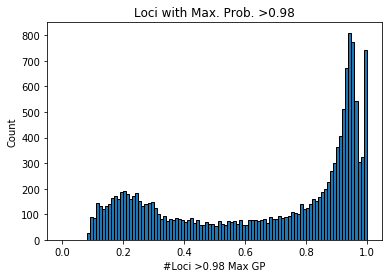

In [74]:
bins = np.linspace(0,1,101)

plt.figure()
ax = plt.gca()
ax.set_title("Loci with Max. Prob. >0.98")
ax.hist(m_ind, bins=bins, ec="k")
ax.set_ylabel("Count")
ax.set_xlabel("#Loci >0.98 Max GP")
plt.show()

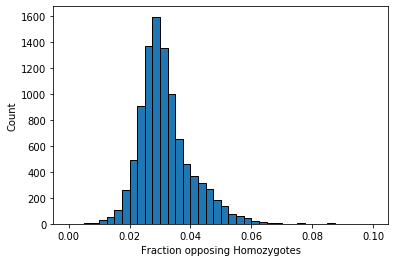

In [16]:
bins = np.linspace(0,0.1,41)

plt.figure()
ax = plt.gca()
ax.hist(frac_mat[3,3:], bins=bins, ec="k")
ax.set_ylabel("Count")
ax.set_xlabel("Fraction opposing Homozygotes")
plt.show()

# Area 51

AttributeError: 'AxesSubplot' object has no attribute 'set_ylablel'

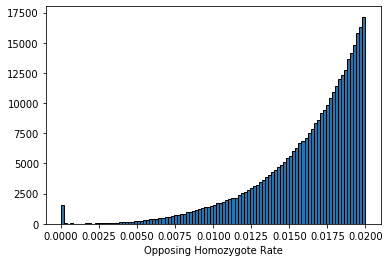

In [48]:
plt.figure()
ax=plt.gca()
ax.hist(df["opp_homo_rate_ch3"], ec="k",bins=100)
ax.set_xlabel("Opposing Homozygote Rate")
ax.set_ylablel("Count")
plt.show()

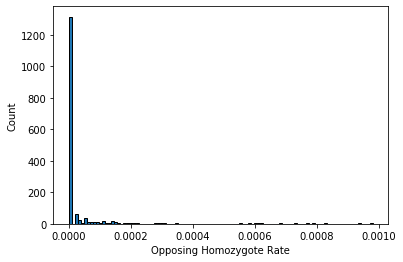

In [53]:
plt.figure()
ax=plt.gca()
ax.hist(df["opp_homo_rate_ch3"], ec="k",bins=100)
ax.set_xlabel("Opposing Homozygote Rate")
ax.set_ylabel("Count")
#ax.set_xlim([0,0.005])
#ax.set_ylim([0,2500])
plt.show()

In [ ]:
df.sort_values(by="opp_homo_rate_ch3")[-50:]